## Clustering based unsupervised crack segmentation approach using GLCM texture properties

### Preparation of dataset by calculating GLCM textures properties on images to train

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt

In [2]:
imgpath = r"C:\Users\shubh\Documents\steel_detection\concrete_crack_detection\Positive"
imgs = ["00001.jpg", "00002.jpg", "00003.jpg", "00004.jpg", "00005.jpg", "00006.jpg"]
imgfiles = [os.path.join(imgpath, img) for img in imgs]
imgfiles

['C:\\Users\\shubh\\Documents\\steel_detection\\concrete_crack_detection\\Positive\\00001.jpg',
 'C:\\Users\\shubh\\Documents\\steel_detection\\concrete_crack_detection\\Positive\\00002.jpg',
 'C:\\Users\\shubh\\Documents\\steel_detection\\concrete_crack_detection\\Positive\\00003.jpg',
 'C:\\Users\\shubh\\Documents\\steel_detection\\concrete_crack_detection\\Positive\\00004.jpg',
 'C:\\Users\\shubh\\Documents\\steel_detection\\concrete_crack_detection\\Positive\\00005.jpg',
 'C:\\Users\\shubh\\Documents\\steel_detection\\concrete_crack_detection\\Positive\\00006.jpg']

In [3]:
# Function to calculate texture properties of a GLCM like correlation, dissimalrity and homogeneity
def GLCM(imgfiles, block=30):
    dissim = []
    correl = []
    homogen = []
    mean = []
    
    for imgfile in imgfiles:
        img = cv2.imread(imgfile, 0)
        (row,col) = img.shape
        for r in range(0,row-block,block):
            for c in range(0,col-block):
                section = img[r:r+block,c:c+block]
                glcm = greycomatrix(section, distances=[5], angles=[0], levels=256,
                            symmetric=True, normed=True)
                
                correl.append(greycoprops(glcm, 'correlation')[0, 0])
                dissim.append(greycoprops(glcm, 'dissimilarity')[0, 0])
                homogen.append(greycoprops(glcm, 'homogeneity')[0, 0])
                mean.append(np.mean(section))
                
    return dissim, correl, homogen

In [4]:
# Calculating texture properties on 10X10 window of image
block = 10
dissim, correl, homogen = GLCM(imgfiles, block)

In [5]:
# Creating dataframe using texture properties
df = pd.DataFrame([])
df['correlation'] = correl
df['dissimilarity'] = dissim
df['homogeneity'] = homogen
df.head()

,correlation,dissimilarity,homogeneity
0,0.092801,2.78,0.256370
1,0.146112,2.38,0.324253
2,0.083852,2.28,0.339900
3,0.066090,2.30,0.347076
4,0.064239,2.30,0.375282


### Fitting K-means clustering for two clusters (one is cracked region and 2nd is good region)

In [77]:
# K-means clustering to label 2 clusters
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=1000, random_state=42)
y = kmeans.fit(df)

In [7]:
y.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
# Predicted clusters centers
kmeans.cluster_centers_

array([[-4.67813164e-02,  3.55844282e+00,  2.87378631e-01],
       [-3.94353142e-01,  3.59859733e+01,  2.97000641e-02]])

### Predicting labels on a test image about which model has no imformation

In [9]:
testimgs = ["00007.jpg"]
testfiles = [os.path.join(imgpath, img) for img in testimgs]
testfiles

['C:\\Users\\shubh\\Documents\\steel_detection\\concrete_crack_detection\\Positive\\00007.jpg']

In [10]:
dissim_test, correl_test, homogen_test = GLCM(testfiles, block)

In [11]:
df_test = pd.DataFrame([])
df_test['correlation'] = correl_test
df_test['dissimilarity'] = dissim_test
df_test['homogeneity'] = homogen_test
df_test.head()

,correlation,dissimilarity,homogeneity
0,-0.290017,5.08,0.162509
1,-0.090576,4.26,0.248735
2,0.054669,3.24,0.341290
3,0.211779,2.52,0.373306
4,0.276769,2.10,0.392157


In [12]:
y_test = kmeans.predict(df_test)

In [13]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
predict_img = cv2.imread(testfiles[0],0)
img_shape = predict_img.shape

In [65]:
predict_label_img = np.zeros(img_shape)

In [66]:
# Segmenting image based on the labels predicted by K-means clustering algorithm
i = 0
(row,col) = img_shape
for r in range(0,row-block,block):
    for c in range(0,col-block):
        predict_label_img[r:r+block,c:c+block] = y_test[i]
        i += 1

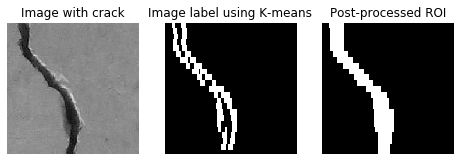

In [76]:
# Plotting original image, predicted image and cleaned image using morpholical operation
_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8,4))

ax0.axis('off')
ax0.set_title("Image with crack")
ax0.imshow(predict_img, cmap='gray')

ax1.axis('off')
ax1.set_title("Image label using K-means")
ax1.imshow(predict_label_img, cmap='gray')

ax2.axis('off')
ax2.set_title("Post-processed ROI")
ax2.imshow(predict_closing, cmap='gray')

plt.show()

In [68]:
# Finding the contour of cracked region
contours, _ = cv2.findContours(predict_closing.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

1

In [69]:
# Drawing contours over predicted crack region
output = predict_crack.copy()
predict_crack = cv2.drawContours(cv2.cvtColor(predict_img,cv2.COLOR_GRAY2RGB), contours, -1, (0,255,0),6)

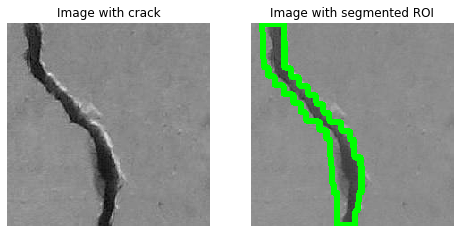

In [75]:
# Plotting the ouput
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))

ax0.axis('off')
ax0.set_title("Image with crack")
ax0.imshow(predict_img, cmap='gray')

ax1.axis('off')
ax1.set_title("Image with segmented ROI")
ax1.imshow(predict_crack, cmap='gray')

plt.show()